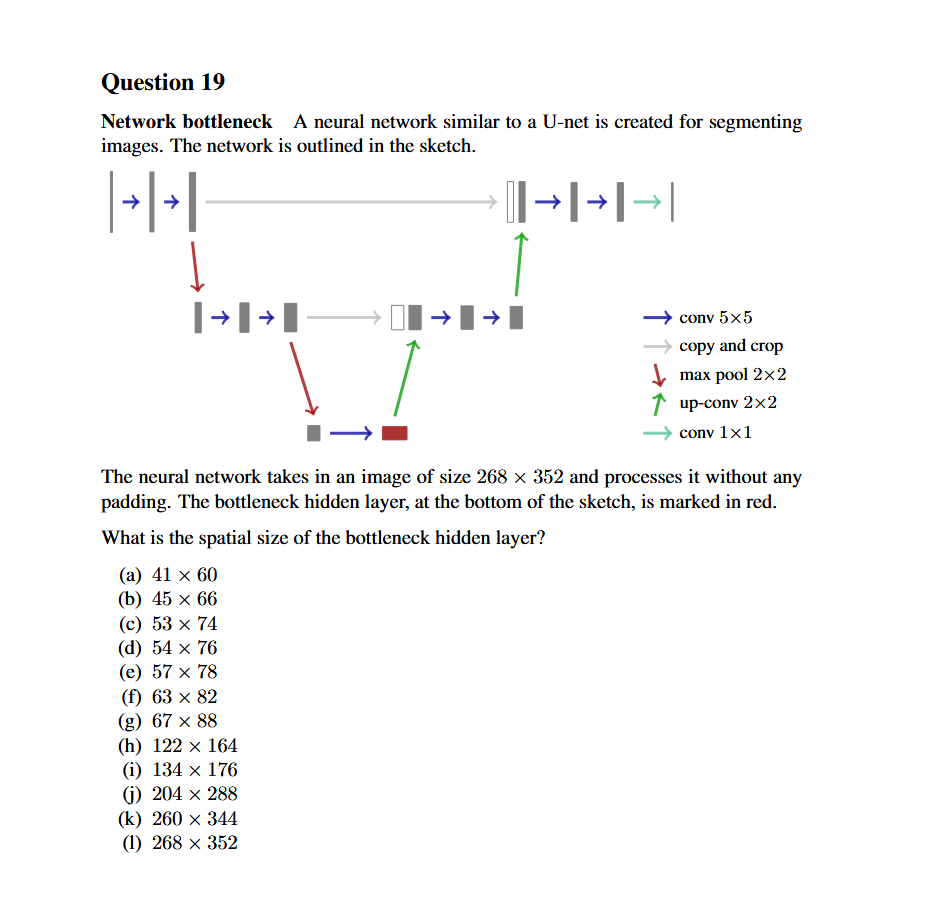

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetLike(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetLike, self).__init__()
        
        # Contracting path (encoder)
        # First level - double convolutions
        self.conv1_1 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=0)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=5, padding=0)  # Fixed input channels
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second level - double convolutions
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=5, padding=0)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=5, padding=0)  # Fixed: was duplicate conv2_1
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottom level - double convolutions
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=5, padding=0)

        
        
        # Expansive path (decoder)
        # Second level
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(256, 128, kernel_size=3, padding=0)  # 256 because of concatenation
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, padding=0)  # Added second conv
        
        # First level
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(128, 64, kernel_size=3, padding=0)  # 128 from concat (64+64)
        self.conv5_2 = nn.Conv2d(64, 64, kernel_size=3, padding=0)   # Added second conv
        
        # Output layer
        self.conv_out = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x, print_dims=False):
        if print_dims:
            print(f"Input: {x.shape} -> spatial dimensions: {x.shape[2]} x {x.shape[3]}")
        
        # Contracting path
        # First level - double convolutions
        conv1_1 = F.relu(self.conv1_1(x))
        if print_dims:
            print(f"After conv1_1: {conv1_1.shape} -> spatial dimensions: {conv1_1.shape[2]} x {conv1_1.shape[3]}")
        
        conv1_2 = F.relu(self.conv1_2(conv1_1))
        if print_dims:
            print(f"After conv1_2: {conv1_2.shape} -> spatial dimensions: {conv1_2.shape[2]} x {conv1_2.shape[3]}")
        
        # Store conv1_2 for skip connection (after both convolutions)
        pool1 = self.pool1(conv1_2)
        if print_dims:
            print(f"After pool1: {pool1.shape} -> spatial dimensions: {pool1.shape[2]} x {pool1.shape[3]}")
        
        # Second level - double convolutions
        conv2_1 = F.relu(self.conv2_1(pool1))
        if print_dims:
            print(f"After conv2_1: {conv2_1.shape} -> spatial dimensions: {conv2_1.shape[2]} x {conv2_1.shape[3]}")
        
        conv2_2 = F.relu(self.conv2_2(conv2_1))
        if print_dims:
            print(f"After conv2_2: {conv2_2.shape} -> spatial dimensions: {conv2_2.shape[2]} x {conv2_2.shape[3]}")
        
        # Store conv2_2 for skip connection (after both convolutions)
        pool2 = self.pool2(conv2_2)
        if print_dims:
            print(f"After pool2: {pool2.shape} -> spatial dimensions: {pool2.shape[2]} x {pool2.shape[3]}")
        
        # Bottom level - double convolutions
        conv3_1 = F.relu(self.conv3_1(pool2))
        if print_dims:
            print(f"After conv3_1: {conv3_1.shape} -> spatial dimensions: {conv3_1.shape[2]} x {conv3_1.shape[3]}")
        
        
        # Expansive path
        # Second level - up-convolution from bottom
        upconv2 = self.upconv2(conv3_1)
        if print_dims:
            print(f"After upconv2: {upconv2.shape} -> spatial dimensions: {upconv2.shape[2]} x {upconv2.shape[3]}")
        
        # Crop conv2_2 to match dimensions with upconv2
        crop2 = self.center_crop(conv2_2, upconv2.shape[2:])
        if print_dims:
            print(f"After crop2 (conv2_2 cropped): {crop2.shape} -> spatial dimensions: {crop2.shape[2]} x {crop2.shape[3]}")
        
        # Concatenate features from contracting path with upsampled features
        concat2 = torch.cat([upconv2, crop2], dim=1)
        if print_dims:
            print(f"After concat2: {concat2.shape} -> spatial dimensions: {concat2.shape[2]} x {concat2.shape[3]}")
        
        # Apply double convolutions to combined features
        conv4_1 = F.relu(self.conv4_1(concat2))
        if print_dims:
            print(f"After conv4_1: {conv4_1.shape} -> spatial dimensions: {conv4_1.shape[2]} x {conv4_1.shape[3]}")
        
        conv4_2 = F.relu(self.conv4_2(conv4_1))
        if print_dims:
            print(f"After conv4_2: {conv4_2.shape} -> spatial dimensions: {conv4_2.shape[2]} x {conv4_2.shape[3]}")
        
        # First level - up-convolution from second level
        upconv1 = self.upconv1(conv4_2)
        if print_dims:
            print(f"After upconv1: {upconv1.shape} -> spatial dimensions: {upconv1.shape[2]} x {upconv1.shape[3]}")
        
        # Crop conv1_2 to match dimensions with upconv1
        crop1 = self.center_crop(conv1_2, upconv1.shape[2:])
        if print_dims:
            print(f"After crop1 (conv1_2 cropped): {crop1.shape} -> spatial dimensions: {crop1.shape[2]} x {crop1.shape[3]}")
        
        # Concatenate features from contracting path with upsampled features
        concat1 = torch.cat([upconv1, crop1], dim=1)
        if print_dims:
            print(f"After concat1: {concat1.shape} -> spatial dimensions: {concat1.shape[2]} x {concat1.shape[3]}")
        
        # Apply double convolutions to the concatenated features
        conv5_1 = F.relu(self.conv5_1(concat1))
        if print_dims:
            print(f"After conv5_1: {conv5_1.shape} -> spatial dimensions: {conv5_1.shape[2]} x {conv5_1.shape[3]}")
        
        conv5_2 = F.relu(self.conv5_2(conv5_1))
        if print_dims:
            print(f"After conv5_2: {conv5_2.shape} -> spatial dimensions: {conv5_2.shape[2]} x {conv5_2.shape[3]}")
        
        # Output layer - 1x1 convolution
        out = self.conv_out(conv5_2)
        if print_dims:
            print(f"Final output: {out.shape} -> spatial dimensions: {out.shape[2]} x {out.shape[3]}")
        
        return out
        
    def center_crop(self, layer, target_size):
        """
        Center crops a tensor to the target size.
        Used for the copy and crop operation in the skip connections.
        """
        _, _, h, w = layer.size()
        target_h, target_w = target_size
        
        start_h = (h - target_h) // 2
        start_w = (w - target_w) // 2
        
        return layer[:, :, start_h:start_h+target_h, start_w:start_w+target_w]


# Example usage with dimension tracking
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create model
    model = UNetLike(in_channels=3, out_channels=1).to(device)
    
    # Test the sizes of input 
    x = torch.randn(1, 3, 268, 352)  # Example input tensor
    
    print("=== SPATIAL DIMENSIONS AT EACH STEP ===")
    output = model(x.to(device), print_dims=True)
    
    print(f"\n=== SUMMARY ===")
    print(f"Input spatial dimensions: 114 x 102")
    print(f"Output spatial dimensions: {output.shape[2]} x {output.shape[3]}")
    print(f"Size reduction: {114 - output.shape[2]} x {102 - output.shape[3]}")
    
    print(f"\n=== DIMENSION LOSS ANALYSIS ===")
    print("Each 5x5 conv with padding=0 reduces dimensions by 4")
    print("Each 3x3 conv with padding=0 reduces dimensions by 2")
    print("Total expected reduction with double convolutions:")
    print("- Encoder: 4+4 = 8 per level (before pooling)")
    print("- Decoder: 2+2 = 4 per level (after upsampling)")
    print(f"- Predicted final size: ~66 x 54")
    print(f"- Actual final size: {output.shape[2]} x {output.shape[3]}")

=== SPATIAL DIMENSIONS AT EACH STEP ===
Input: torch.Size([1, 3, 268, 352]) -> spatial dimensions: 268 x 352
After conv1_1: torch.Size([1, 64, 264, 348]) -> spatial dimensions: 264 x 348
After conv1_2: torch.Size([1, 64, 260, 344]) -> spatial dimensions: 260 x 344
After pool1: torch.Size([1, 64, 130, 172]) -> spatial dimensions: 130 x 172
After conv2_1: torch.Size([1, 128, 126, 168]) -> spatial dimensions: 126 x 168
After conv2_2: torch.Size([1, 128, 122, 164]) -> spatial dimensions: 122 x 164
After pool2: torch.Size([1, 128, 61, 82]) -> spatial dimensions: 61 x 82
After conv3_1: torch.Size([1, 256, 57, 78]) -> spatial dimensions: 57 x 78
After upconv2: torch.Size([1, 128, 114, 156]) -> spatial dimensions: 114 x 156
After crop2 (conv2_2 cropped): torch.Size([1, 128, 114, 156]) -> spatial dimensions: 114 x 156
After concat2: torch.Size([1, 256, 114, 156]) -> spatial dimensions: 114 x 156
After conv4_1: torch.Size([1, 128, 112, 154]) -> spatial dimensions: 112 x 154
After conv4_2: torch.

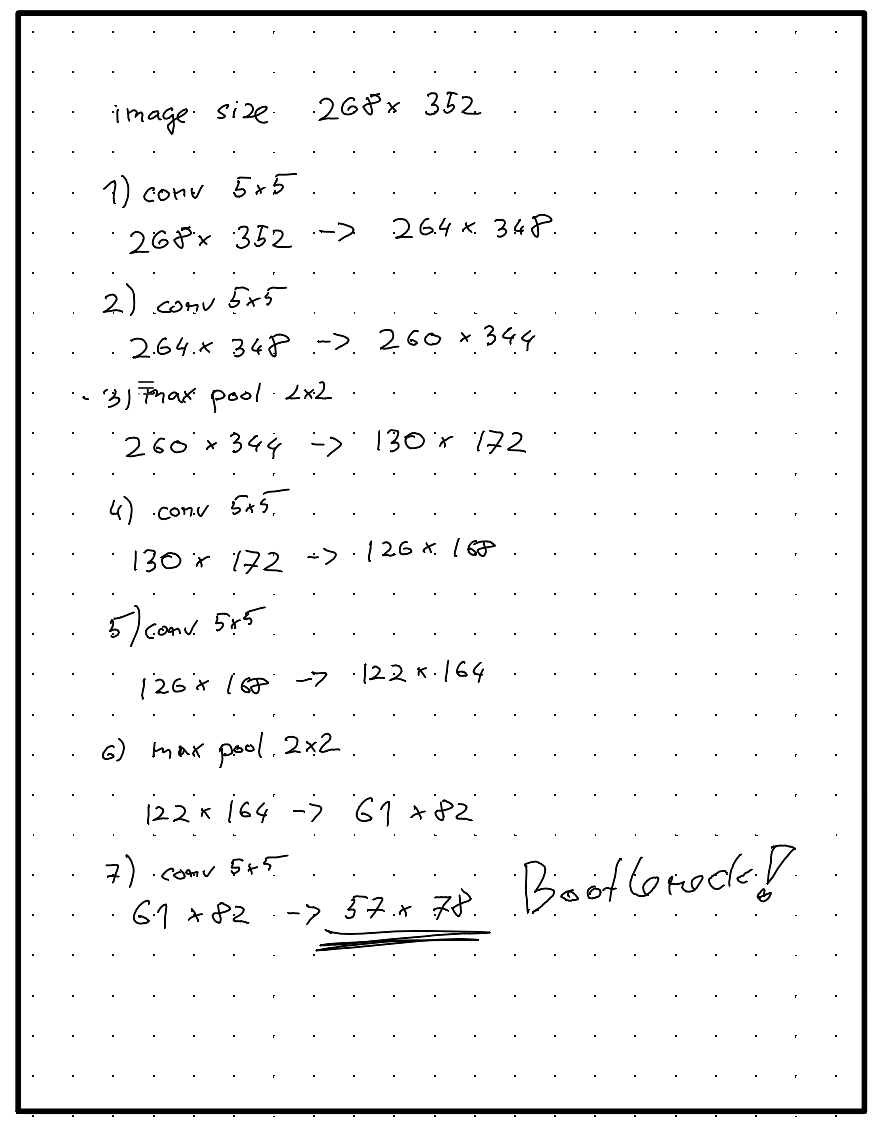